# Clustering analysis using scanpy on the developing-brain meta-atlas  
I reanalyzed the dataset using the scanpy pipeline to validate the results obtained with Cytograp, after eliminating some clusters and cc genesh. Specifically, I preprocessed, integrated, and clustered the dataset, and generated all the panels for Figure S1.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
from harmony import harmonize
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(7, 4))
sc.settings.verbosity = 3

-----
anndata     0.10.8
scanpy      1.10.1
-----
PIL                         10.2.0
anyio                       NA
arrow                       1.3.0
asciitree                   NA
asttokens                   NA
astunparse                  1.6.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.11.0
bottleneck                  1.3.7
brotli                      1.0.9
certifi                     2024.08.30
cffi                        1.16.0
charset_normalizer          2.0.4
cloudpickle                 3.0.0
colorama                    0.4.6
comm                        0.2.1
cycler                      0.10.0
cython_runtime              NA
dask                        2024.7.0
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
defusedxml                  0.7.1
executing                   0.8.3
fastjsonschema              NA
fqdn                        NA
h5py                        3.9.0
ha

#### For this purpose, I loaded the dataset `noAdolescence_nocc_noclusters_FirstManualAnnotations.h5ad`, which I generated in the notebook `from_noAdolescence_to_final_training_dataset.ipynb`.

In [3]:
adata = sc.read_h5ad('/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/noAdolescence_nocc_noclusters_FirstManualAnnotations.h5ad')

#### Changing index from gene endemble IDs to gene names

In [4]:
adata.var = (
    adata.var
    .reset_index()                      
    .rename(columns={'index': 'ensemble_ids'})  
    .set_index('Gene')                  
)

adata.obs['Clusters'] = adata.obs['Clusters'].astype('category')

/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['LINC00115', 'FAM41C', 'NOC2L', 'HES4', 'RNF223']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


In [15]:
ccGenesHuman = np.loadtxt('/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/ccGenesHuman.txt', dtype=str)
mask = ~adata.var_names.isin(ccGenesHuman)
adata = adata[:, mask]

In [6]:
adata = adata[:, ~adata.var_names.str.startswith(('MT-', 'RP'))]

#### I normalized and log-transformed the data, computed the highly variable genes, scaled the data, and performed PCA.

In [7]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="auto", use_highly_variable =True)

/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:15)
extracting highly variable genes
    finished (0:00:06)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    with n_comps=50


/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


    finished (0:00:34)


#### I integrated the dataset using the keys `donor_kim`, `assay`, and `suspension_type`, setting a random state to ensure reproducibility.

In [8]:
adata.obsm['X_pca_harmony'] = harmonize(
    adata.obsm['X_pca'],
    adata.obs,
    ['donor_kim', 'assay', 'suspension_type'],
    theta=1,                            
    max_iter_harmony=30,    
    random_state=0
)

	Initialization is completed.
	Completed 1 / 30 iteration(s).
	Completed 2 / 30 iteration(s).
	Completed 3 / 30 iteration(s).
Reach convergence after 3 iteration(s).


#### I then computed the neighborhood graph and generated a UMAP embedding.

In [9]:
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=50, use_rep='X_pca_harmony')
sc.tl.umap(adata)

computing neighbors


2025-02-09 12:53:46.216558: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-09 12:53:46.265500: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-09 12:53:47.846627: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:51)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:05:30)


#### I plotted the UMAP, coloring the cells by `donor_kim` to verify that the integration was successful.

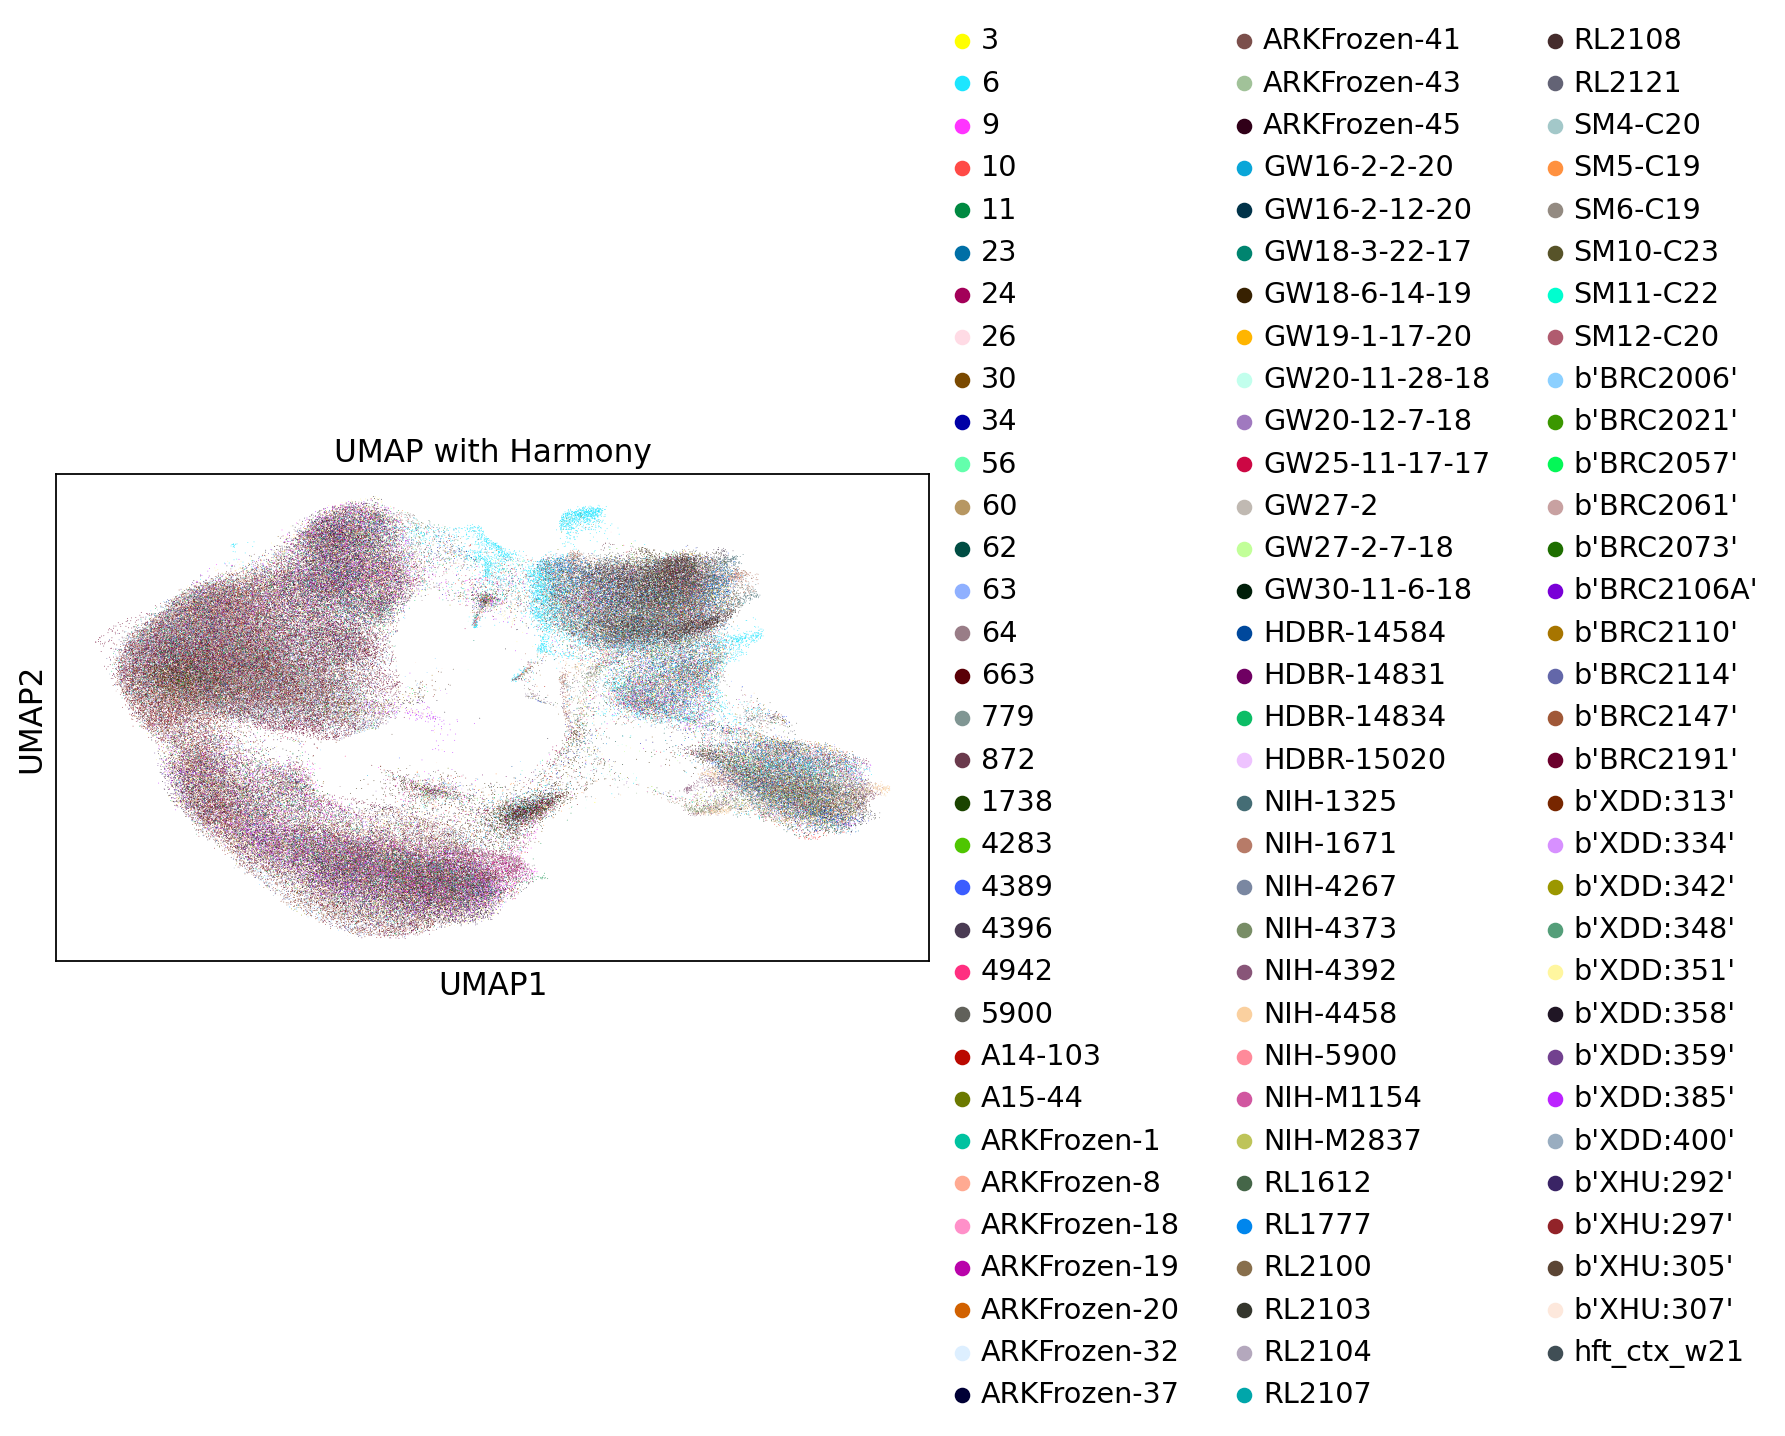

In [10]:
sc.pl.umap(adata, color=['donor_kim'], title='UMAP with Harmony')

#### I applied the Leiden clustering algorithm and visualized the results in panels A and B of Figure S1.

In [11]:
sc.tl.leiden(
    adata,
    resolution=0.8,
    random_state=0,
    flavor="igraph",
    n_iterations=10,
    directed=False,
)

running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:52)


## Figure S1

#### PANELS A-B

In [12]:
developmental_stage_new_palette = ["#0cc0aa", "#b75970", "#7fdc64", "#2c647e", "#b1bf81", "#c5089e", "#8aafcf", "#513886", "#f4bb8f", "#b94414", "#9a82e0", "#1c5f1e", "#ee80fe", "#2cf52b", "#6118df", "#cace01", "#ea1349", "#f3c5fa", "#4b481f", "#fbbd13", "#208eb7", "#bce333", "#bc5857", "#2af385", "#eb1241", "#90d796", "#d148d3", "#26496d", "#f8cca6", "#7f73ed", "#6c8c60", "#e9c9fa", "#621da6", "#4bd6fd", "#1b511d", "#e1c637", "#ae896e", "#15974d", "#d6790b", "#604020", "#2af385", "#4bd6fd", "#d6790b", "#6c8c60", "#58b5e1"]

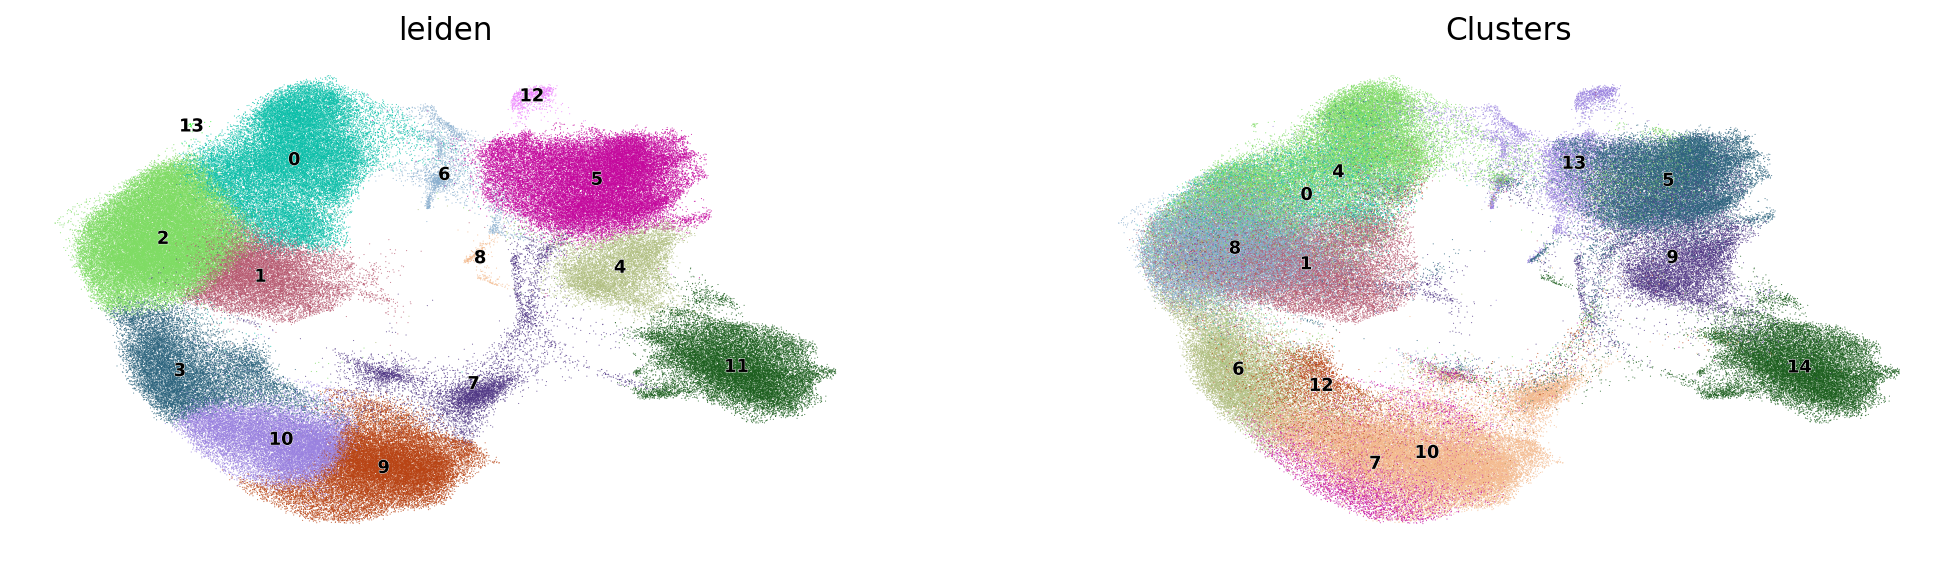

In [13]:
ax = sc.pl.embedding(
    adata,
    basis='X_umap',
    color=['leiden', 'Clusters'],
    palette=developmental_stage_new_palette,
    size=1,
    alpha=0.8,
    legend_loc='on data',
    legend_fontsize=8,
    legend_fontoutline=0.4,
    frameon=False,
    show=False,  
    return_fig=True
)

# uncomment this to save high quality figure
#ax.savefig('fig_S1_panels_A_B.png', dpi=600, bbox_inches='tight')

#### PANELS C-D

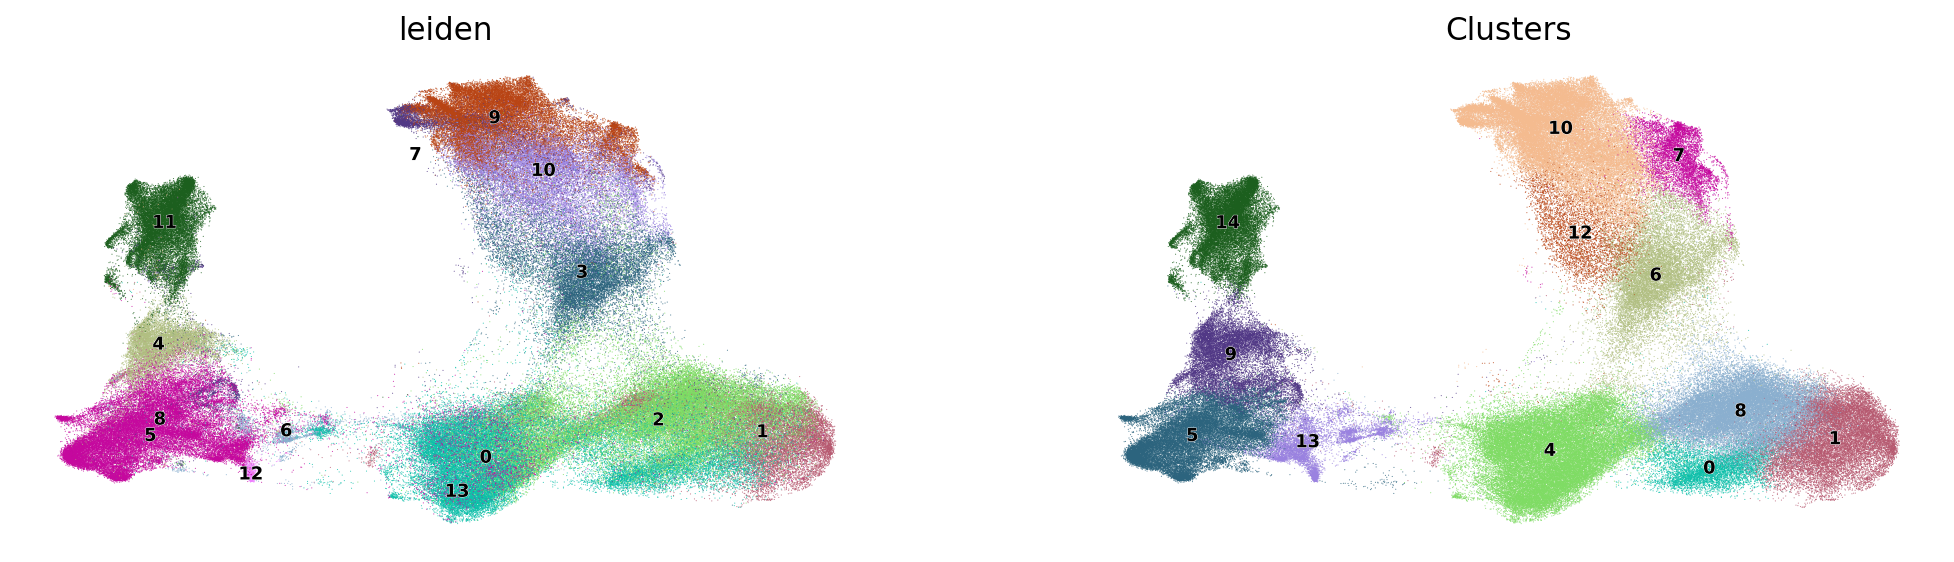

In [14]:
ax = sc.pl.embedding(
    adata,
    basis='UMAP',
    color=['leiden', 'Clusters'],
    palette=developmental_stage_new_palette,
    size=1,
    alpha=0.8,
    legend_loc='on data',
    legend_fontsize=8,
    legend_fontoutline=0.4,
    frameon=False,
    show=False,
    return_fig=True
)

# uncomment this to save high quality figure
#ax.savefig('fig_S1_panels_C_D.png', dpi=600, bbox_inches='tight')